In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Generative Adversarial Network - GAN  
### deep learning method in which two neural networks compete with each other in a game, learning to generate new data with the same statistics as the training set.
### The Generator attempts to fool the Discriminator, which is tasked with accurately distinguishing between produced and genuine data.  



In [2]:
from tqdm.notebook import tqdm

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import random
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("splcher/animefacedataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Path to dataset files: /kaggle/input/animefacedataset
['images']


In [6]:
print(os.listdir(path+'/images')[:10])

['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg', '40739_2013.jpg', '42515_2013.jpg', '52482_2015.jpg', '46555_2014.jpg', '11579_2005.jpg']


In [7]:
image_size=64
batch_size=128
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

In [8]:
train_dataset = ImageFolder(path, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*stats)]))

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [9]:
train_loader

In [10]:
def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][1]

In [11]:
def show_images(images, nmax=64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(b,nmax=64):
    for images,_ in b:
        show_images(images,nmax)
        break

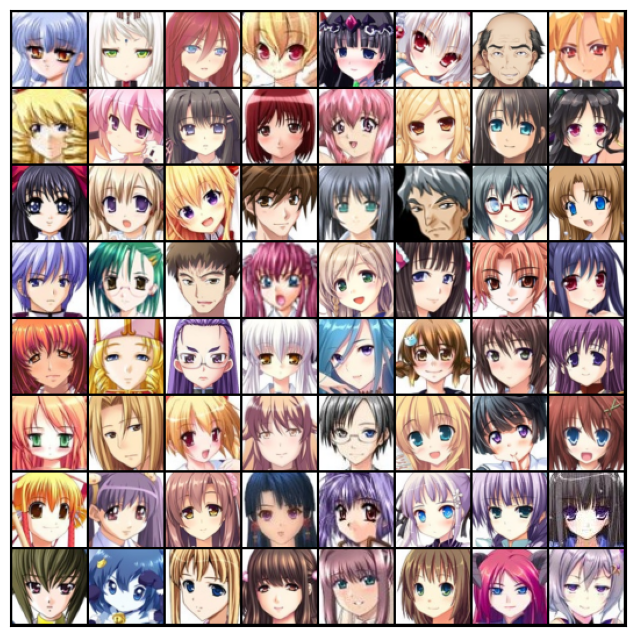

In [12]:
images,_ = next(iter(train_loader))
show_images(images,nmax=64)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
train_loader

# Discriminator

### output = ((input - kernel_size + 2 padding ) / stride) + 1

In [16]:
discriminator = nn.Sequential(

    #in : 3x64x64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #out : 64x32x32

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out : 128x16x16

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out : 256x8x8

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out : 512x4x4

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #out : 1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

# Discriminator Training  
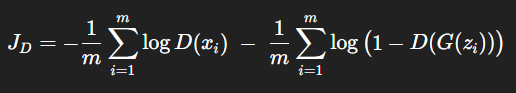

### Jd : discriminator’s ability to distinguish between produced and actual samples.
### logD(xi) : log-likelihood of correctly classifying real data as genuine
### log(1−𝐷(𝐺(𝑧𝑖))) : log-likelihood of correctly classifying generated samples as fake.

In [19]:
def discriminator_training(real_images, optimizer_d):
    optimizer_d.zero_grad()

    #passing real images to discriminator
    real_pred = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_pred, real_targets)
    real_score = torch.mean(real_pred).item()

    #generate fake images
    latent = torch.randn(batch_size, latent_size,1,1,device=device)
    fake_images = generator(latent)

    #pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0),1,device=device)
    fake_pred = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_pred, fake_targets)
    fake_score = torch.mean(fake_pred).item()

    #updating discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    optimizer_d.step()

    return loss.item(), real_score, fake_score

# Generator
input : a vector or a matrix of random numbers (referred to as a latent tensor).  
it is used as a seed for generating an image  

the generator converts the latent tensor(128,1,1) to image tensor(3x28x28) using ConvTranspose2d - transposed convolution (also referred to as a deconvolution).

In [20]:
latent_size=128

In [21]:
generator = nn.Sequential(
    #in : latent_sizex1x1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #out : 512x4x4

    nn.ConvTranspose2d(512,256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out : 256x8x8

    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out : 128x16x16

    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out : 64x32x32

    nn.ConvTranspose2d(64,3,kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #out : 3x64x64
)

In [22]:
generator = to_device(generator,device)

In [23]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

# Generator Training
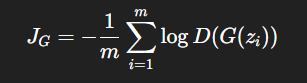

### Jg : measure how well the generator is fooling the discriminator.
### log(D(G(xi)) : log probability that the discriminator is WRONG on generated samples.

In [24]:
def generator_training(optimizer_g):
    optimizer_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    pred = discriminator(fake_images)
    target = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(pred,target)

    loss.backward()
    optimizer_g.step()

    return loss.item()

## visualizing intermidate results

In [25]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [26]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99990714..0.9999869].


Saving generated-images-0000.png


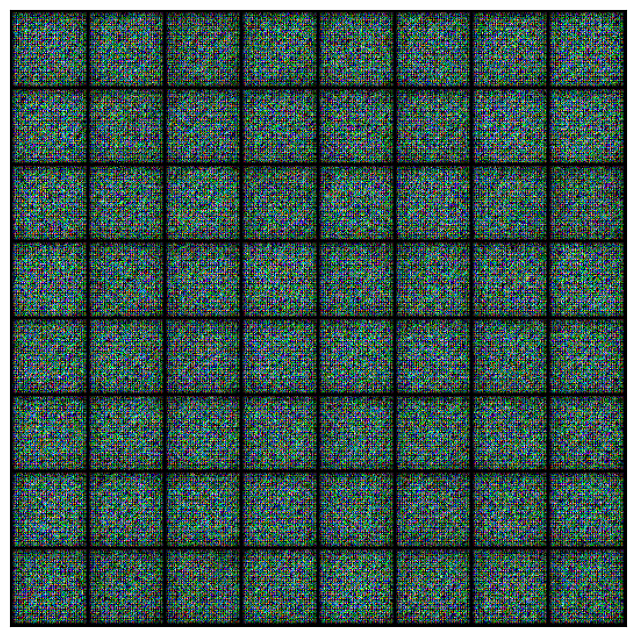

In [27]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

# Full training loop

### Parameters

In [28]:
lr = 0.0002
beta1 = 0.5

In [29]:
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

### training

In [30]:
def fit(epochs, start_idx=1):
    torch.cuda.empty_cache()
    
    # Lists to track losses
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        # Track losses for current epoch
        loss_d_epoch = 0
        loss_g_epoch = 0
        real_score_epoch = 0
        fake_score_epoch = 0
        
        # Progress bar for batches in current epoch
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=True)
        
        for real_images, _ in pbar:
            # Train discriminator
            loss_d, real_score, fake_score = discriminator_training(real_images, optimizer_d)
            loss_d_epoch += loss_d
            real_score_epoch += real_score
            fake_score_epoch += fake_score
            
            # Train generator
            loss_g = generator_training(optimizer_g)
            loss_g_epoch += loss_g
            
            # Update progress bar with current batch losses
            pbar.set_postfix({
                'D_loss': f'{loss_d:.4f}',
                'G_loss': f'{loss_g:.4f}',
                'Real_score': f'{real_score:.4f}',
                'Fake_score': f'{fake_score:.4f}'
            })
        
        # Calculate average losses for the epoch
        num_batches = len(train_loader)
        avg_loss_d = loss_d_epoch / num_batches
        avg_loss_g = loss_g_epoch / num_batches
        avg_real_score = real_score_epoch / num_batches
        avg_fake_score = fake_score_epoch / num_batches
        
        # Store losses
        losses_d.append(avg_loss_d)
        losses_g.append(avg_loss_g)
        real_scores.append(avg_real_score)
        fake_scores.append(avg_fake_score)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{epochs}] - D_loss: {avg_loss_d:.4f}, G_loss: {avg_loss_g:.4f}, '
              f'Real_score: {avg_real_score:.4f}, Fake_score: {avg_fake_score:.4f}')
        
        # Save generated image samples every epoch
        save_samples(epoch + start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [31]:
epochs = 20  # You can adjust this

losses_g, losses_d, real_scores, fake_scores = fit(epochs)

Epoch 1/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/20] - D_loss: 0.7163, G_loss: 5.2986, Real_score: 0.7760, Fake_score: 0.2283
Saving generated-images-0001.png


Epoch 2/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/20] - D_loss: 0.6584, G_loss: 5.1026, Real_score: 0.7836, Fake_score: 0.2122
Saving generated-images-0002.png


Epoch 3/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/20] - D_loss: 0.5158, G_loss: 5.5240, Real_score: 0.8203, Fake_score: 0.1775
Saving generated-images-0003.png


Epoch 4/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/20] - D_loss: 0.3810, G_loss: 5.9284, Real_score: 0.8633, Fake_score: 0.1350
Saving generated-images-0004.png


Epoch 5/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/20] - D_loss: 0.3247, G_loss: 6.8412, Real_score: 0.8897, Fake_score: 0.1089
Saving generated-images-0005.png


Epoch 6/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/20] - D_loss: 0.2377, G_loss: 7.2568, Real_score: 0.9152, Fake_score: 0.0839
Saving generated-images-0006.png


Epoch 7/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/20] - D_loss: 0.2217, G_loss: 7.7151, Real_score: 0.9252, Fake_score: 0.0738
Saving generated-images-0007.png


Epoch 8/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/20] - D_loss: 0.1777, G_loss: 7.7754, Real_score: 0.9382, Fake_score: 0.0603
Saving generated-images-0008.png


Epoch 9/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/20] - D_loss: 0.1977, G_loss: 8.3354, Real_score: 0.9407, Fake_score: 0.0605
Saving generated-images-0009.png


Epoch 10/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/20] - D_loss: 0.1422, G_loss: 8.2357, Real_score: 0.9479, Fake_score: 0.0512
Saving generated-images-0010.png


Epoch 11/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/20] - D_loss: 0.1504, G_loss: 8.8376, Real_score: 0.9494, Fake_score: 0.0502
Saving generated-images-0011.png


Epoch 12/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/20] - D_loss: 0.1958, G_loss: 9.0944, Real_score: 0.9454, Fake_score: 0.0550
Saving generated-images-0012.png


Epoch 13/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/20] - D_loss: 0.1622, G_loss: 8.7067, Real_score: 0.9503, Fake_score: 0.0492
Saving generated-images-0013.png


Epoch 14/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/20] - D_loss: 0.0973, G_loss: 8.2003, Real_score: 0.9638, Fake_score: 0.0359
Saving generated-images-0014.png


Epoch 15/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/20] - D_loss: 0.1563, G_loss: 10.0585, Real_score: 0.9541, Fake_score: 0.0461
Saving generated-images-0015.png


Epoch 16/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/20] - D_loss: 0.1471, G_loss: 9.4497, Real_score: 0.9550, Fake_score: 0.0450
Saving generated-images-0016.png


Epoch 17/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/20] - D_loss: 0.1256, G_loss: 9.0423, Real_score: 0.9586, Fake_score: 0.0398
Saving generated-images-0017.png


Epoch 18/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/20] - D_loss: 0.1534, G_loss: 11.4981, Real_score: 0.9571, Fake_score: 0.0436
Saving generated-images-0018.png


Epoch 19/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/20] - D_loss: 0.0956, G_loss: 9.1157, Real_score: 0.9648, Fake_score: 0.0352
Saving generated-images-0019.png


Epoch 20/20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/20] - D_loss: 0.1818, G_loss: 10.6164, Real_score: 0.9515, Fake_score: 0.0485
Saving generated-images-0020.png


In [32]:
# Save the complete training state
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_g_state_dict': optimizer_g.state_dict(),
    'optimizer_d_state_dict': optimizer_d.state_dict(),
    'losses_g': losses_g,
    'losses_d': losses_d,
    'real_scores': real_scores,
    'fake_scores': fake_scores,
    'latent_size': latent_size,
    'image_size': image_size
}, 'Anime_Face_GAN.pth')

# Save just the generator (for inference only)
torch.save(generator.state_dict(), 'generator_final.pth')

print("Models saved successfully!")
print("Anime_Face_GAN.pth' (full training state)")
print("generator_final.pth (generator only)")

Models saved successfully!
Anime_Face_GAN.pth' (full training state)
generator_final.pth (generator only)


In [33]:
def plot_losses(losses_g, losses_d):
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Generator and Discriminator Loss
    plt.subplot(1, 2, 1)
    plt.plot(losses_g, label='Generator Loss', color='blue', linewidth=2)
    plt.plot(losses_d, label='Discriminator Loss', color='red', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Generator and Discriminator Loss', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Real and Fake Scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, label='Real Score', color='green', linewidth=2)
    plt.plot(fake_scores, label='Fake Score', color='orange', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Discriminator Scores', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
    plt.show()

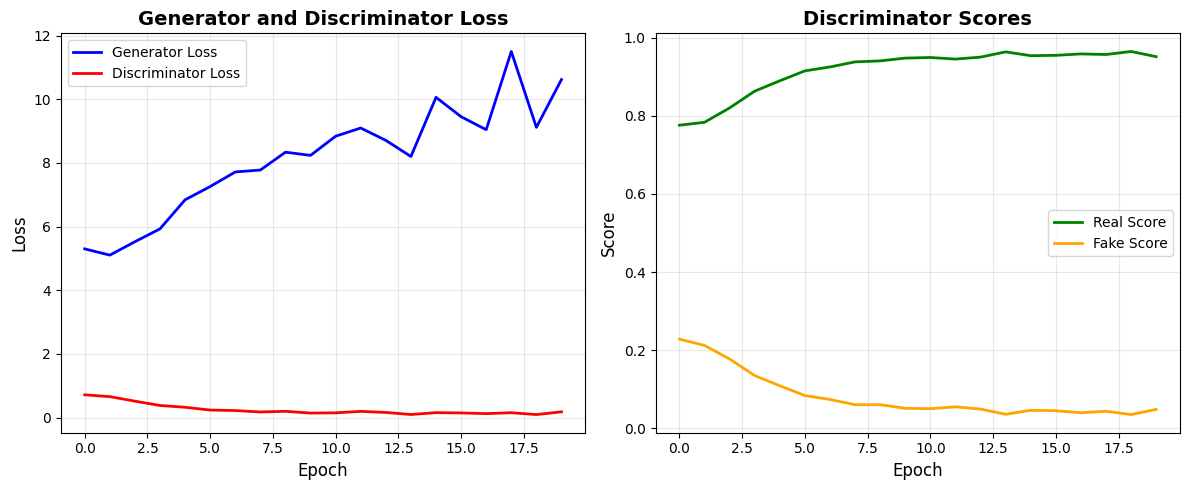

In [34]:
plot_losses(losses_g, losses_d)

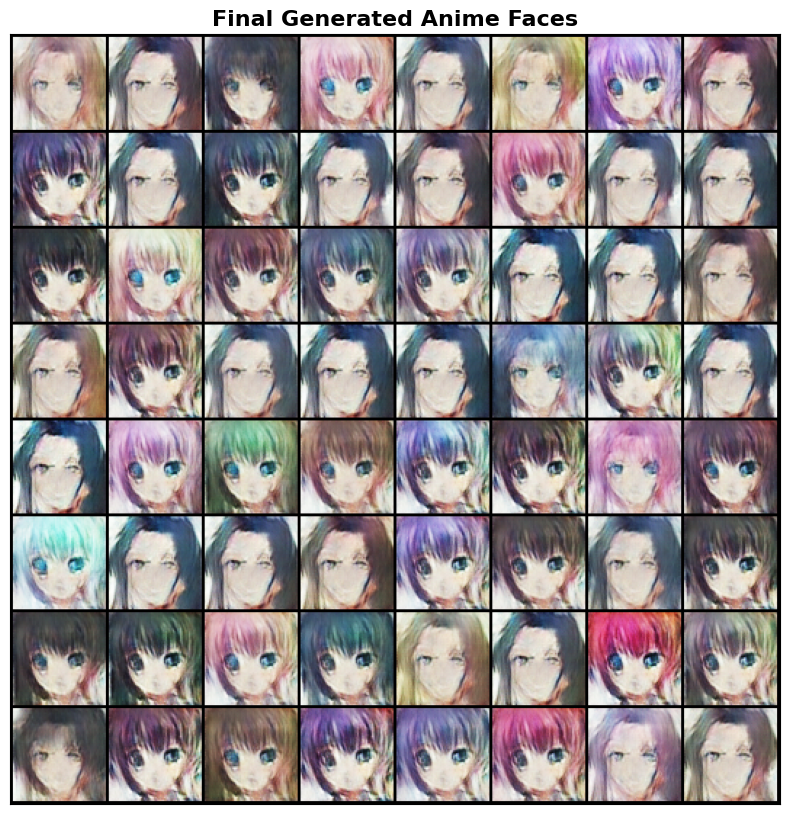

In [35]:
def plot_final_generated_images(num_images=64):
    """Generate and display final results from trained generator"""
    generator.eval()
    
    with torch.no_grad():
        # Generate random latent vectors
        latent = torch.randn(num_images, latent_size, 1, 1, device=device)
        
        # Generate images
        fake_images = generator(latent)
        
        # Plot
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Final Generated Anime Faces', fontsize=16, fontweight='bold')
        ax.imshow(make_grid(denorm(fake_images.cpu()), nrow=8).permute(1, 2, 0))
        plt.savefig('final_generated_images.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    generator.train()

plot_final_generated_images(64)

# Mode Collapse
#### It occurs when the generator produces a limited set of outputs—often repetitive or nearly identical samples—instead of capturing the full diversity of the training data distribution.  
### “Why learn all faces if one face fools D every time?”

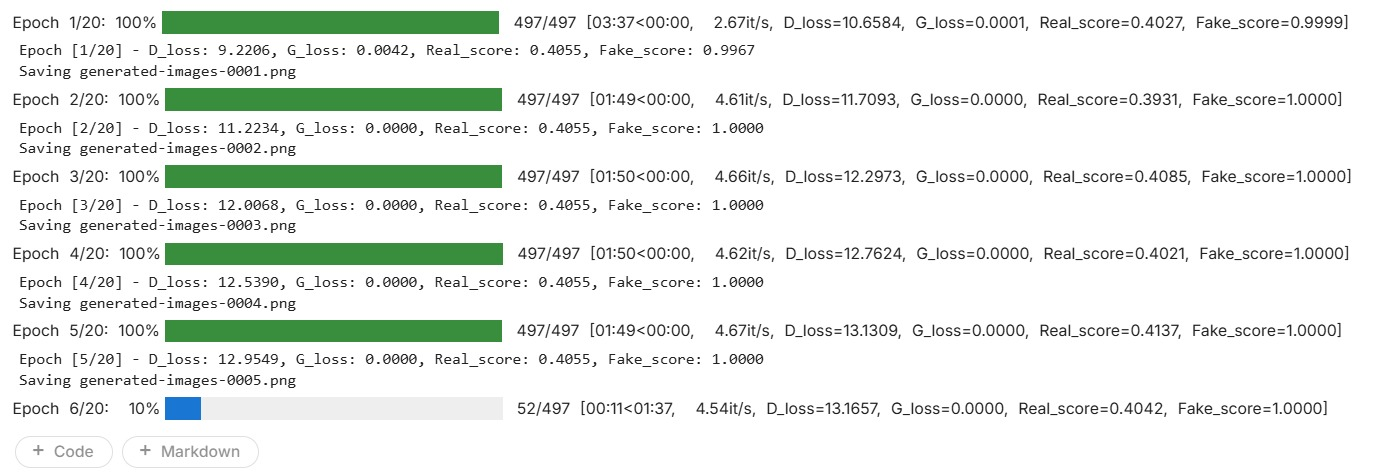

## Why mode collapse happened in this case?  
#### 1.Generator loss ≈ 0.0000 : The generator is consistently fooling the discriminator, indicating it has found an easy pattern rather than learning the full data distribution.  
#### 2.Fake_score ≈ 1.0000 (constant) : The discriminator classifies almost all generated samples as real, a strong sign that the generator has collapsed to a limited set of outputs.  
#### 3.Discriminator loss keeps increasing	: The discriminator is failing to distinguish real and fake samples, showing that training has become unbalanced in favor of the generator.  


## Few ways to solve mode collapse :   
#### 1. Balance generator & discriminator  
#### 2. lower generator learning rate  
#### 3. label smoothing - Reduces discriminator overconfidence by softening real labels (0.9 instead of 1.0).  
#### 4. Add Noise to Discriminator Inputs  
#### 5. Feature Matching - Trains the generator to match statistics of real data features rather than directly fooling the discriminator.


In [40]:
import imageio
import os

image_folder = "/kaggle/working/generated"
gif_path = "/kaggle/working/generated/GAN_training.gif"

images = []

for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith(".png"):
        file_path = os.path.join(image_folder, file_name)
        images.append(imageio.imread(file_path))

imageio.mimsave(gif_path, images, fps=2)

/tmp/ipykernel_55/3243267858.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
